In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df = pd.read_csv('data.csv')

In [25]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Train decision tree with default parameters

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt', DecisionTreeRegressor(random_state=42))])

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

In [29]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 0.000
MAE: 0.000
R2: 1.000

Test Set:
MSE: 9.372
MAE: 2.131
R2: 0.805


In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.79399773 0.79941775 0.79144076 0.78148488 0.78076705]
R^2 trung bình: 0.789 ± 0.007

MSE: [10.01699164  9.64651811 10.09640568 10.32070215 10.76427974]
MSE trung bình: 10.169± 0.368

MAE: [2.14958217 2.12451253 2.14767345 2.1395932  2.16857063]
MAE trung bình: 2.146 ± 0.014


In [31]:
max_depths = np.arange(1, 21)
mse_train_values, mse_test_values = [], []
mae_train_values, mae_test_values = [], []
r2_train_values, r2_test_values = [], []

for depth in max_depths:
    model = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(max_depth=depth))
    ])
    model.fit(X_train, y_train)
    
    mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
    mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)

    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)

    mae_train_values.append(mae_train)
    mae_test_values.append(mae_test)
    
    r2_train_values.append(r2_train)
    r2_test_values.append(r2_test)

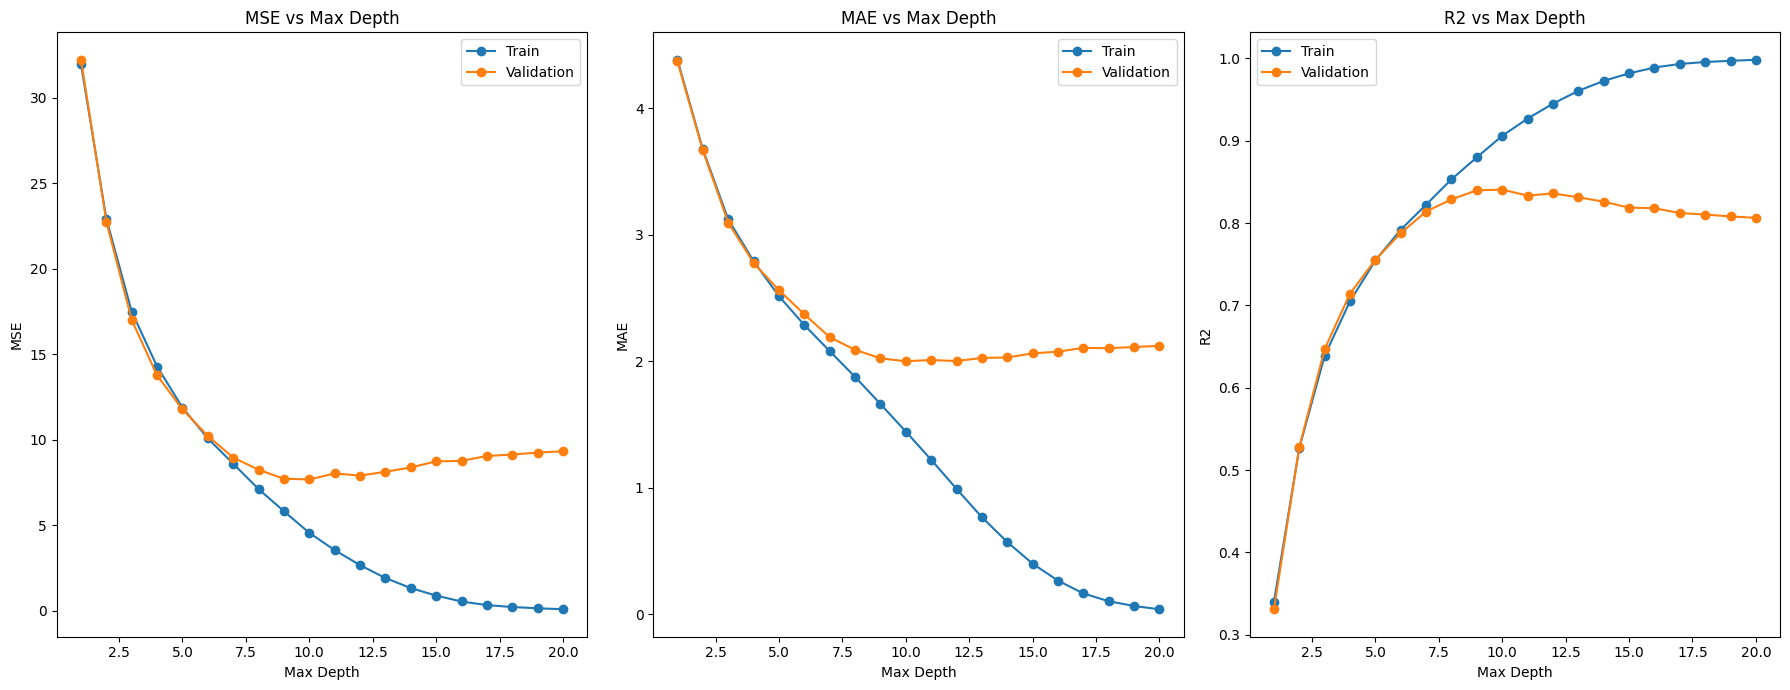

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 7))

plt.subplot(1, 3, 1)
plt.plot(max_depths, mse_train_values, label='Train', marker='o')
plt.plot(max_depths, mse_test_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE vs Max Depth')

plt.subplot(1, 3, 2)
plt.plot(max_depths, mae_train_values, label='Train', marker='o')
plt.plot(max_depths, mae_test_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE vs Max Depth')

plt.subplot(1, 3, 3)
plt.plot(max_depths, r2_train_values, label='Train', marker='o')
plt.plot(max_depths, r2_test_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('R2')
plt.legend()
plt.title('R2 vs Max Depth')

plt.tight_layout()
plt.show()

As we can see here, the decision tree is completely fitted to our training data, leading to a "perfect" result. However, it does not perform well on the validation and test sets, which is a sign of **overfitting**. 

# Inference from plotted graph

In [33]:
k_max_depth = np.argmin(mse_test_values)
best_max_depth = max_depths[k_max_depth]
print(f'Best Max Depth: {best_max_depth}')
print(f'Train MSE: {mse_test_values[k_max_depth]:.3f}')

Best Max Depth: 10
Train MSE: 7.669


In [34]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(max_depth=best_max_depth))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt', DecisionTreeRegressor(max_depth=np.int64(10)))])

In [35]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 4.547
MAE: 1.445
R2: 0.906

Test Set:
MSE: 7.795
MAE: 2.002
R2: 0.838


# Pruning decision tree having max_depth = 13

In [36]:
import pandas as pd
df = pd.read_csv('data_encoded.csv')

In [37]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
model = DecisionTreeRegressor(random_state=42, max_depth=13)

path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas[:-1], path.impurities[:-1]

ccp_alphas.shape, impurities.shape

((2656,), (2656,))

In [40]:
ccp_alphas

array([0.00000000e+00, 3.98025792e-05, 3.98025792e-05, ...,
       2.44285898e+00, 2.79889466e+00, 6.60340123e+00])

In [41]:
df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
from sklearn.model_selection import cross_val_score

trees = []
scores = []

for ccp_alpha in ccp_alphas:
    tree = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha))
    ])
    tree.fit(X_train, y_train)
    trees.append(tree)

    score = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    scores.append(np.mean(score))

MSE_train = [mean_squared_error(y_train, tree.predict(X_train)) for tree in trees]
MSE_test = [mean_squared_error(y_test, tree.predict(X_test)) for tree in trees]

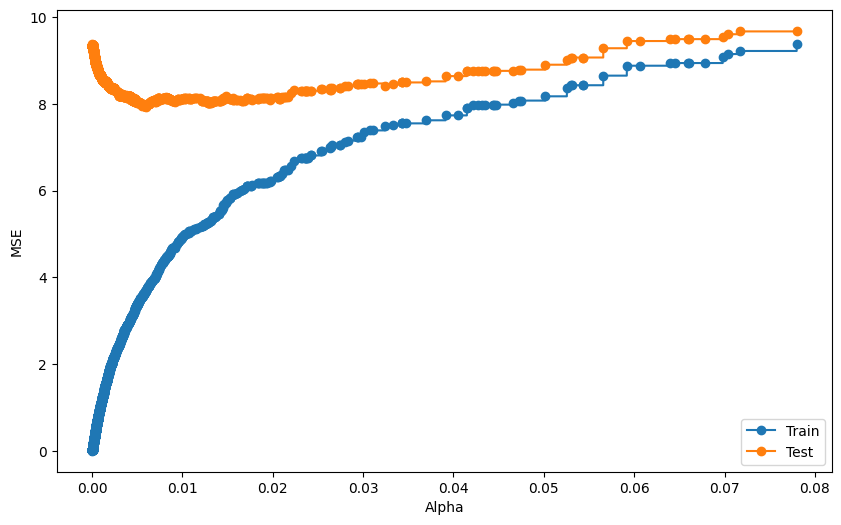

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Alpha')
ax.set_ylabel('MSE')
    
ax.plot(ccp_alphas[:2620], MSE_train[:2620], marker='o', label='Train', drawstyle='steps-post')
ax.plot(ccp_alphas[:2620], MSE_test[:2620], marker='o', label='Test', drawstyle='steps-post')

ax.legend()
plt.show()

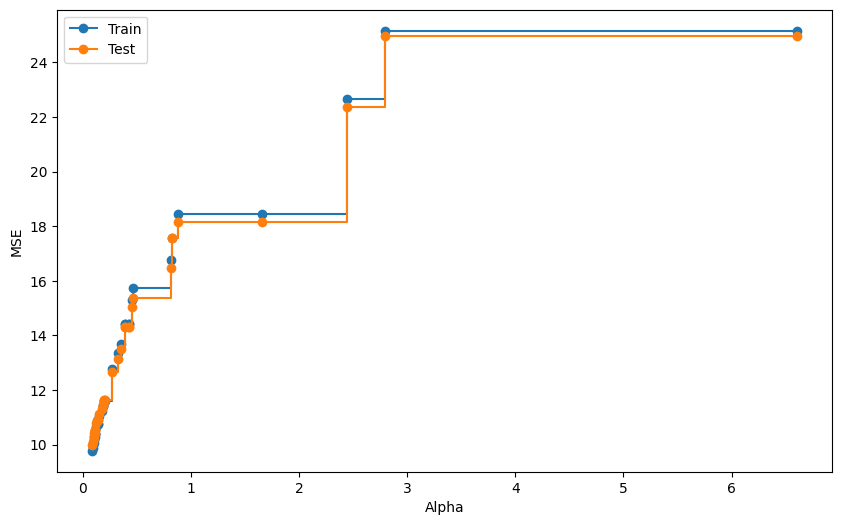

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Alpha')
ax.set_ylabel('MSE')
    
ax.plot(ccp_alphas[2620:], MSE_train[2620:], marker='o', label='Train', drawstyle='steps-post')
ax.plot(ccp_alphas[2620:], MSE_test[2620:], marker='o', label='Test', drawstyle='steps-post')

ax.legend()
plt.show()

Best alpha: 0.014447222009716376
Best MSE: 8.84037783627623


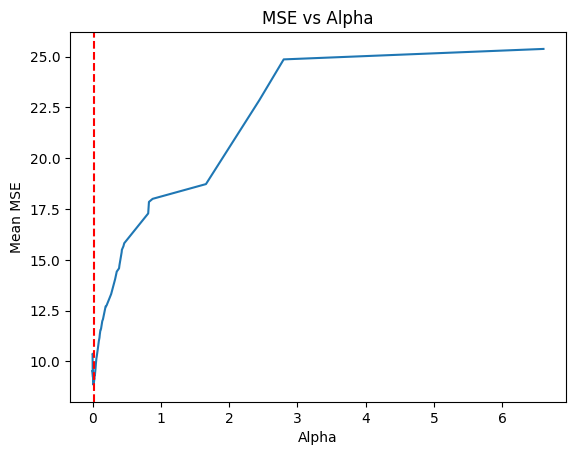

In [45]:
scores = [-score for score in scores]

plt.plot(ccp_alphas[:], scores[:])
plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.title('MSE vs Alpha')

best_idx = np.argmin(scores)
plt.axvline(x=ccp_alphas[best_idx], color='r', linestyle='--', label=f'Best Alpha: {ccp_alphas[best_idx]:.4f}')

print(f"Best alpha: {ccp_alphas[best_idx]}")
print(f"Best MSE: {scores[best_idx]}")

In [46]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alphas[best_idx]))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=np.float64(0.014447222009716376),
                                       random_state=42))])

In [47]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 5.598
MAE: 1.806
R2: 0.884

Test Set:
MSE: 8.097
MAE: 2.087
R2: 0.832


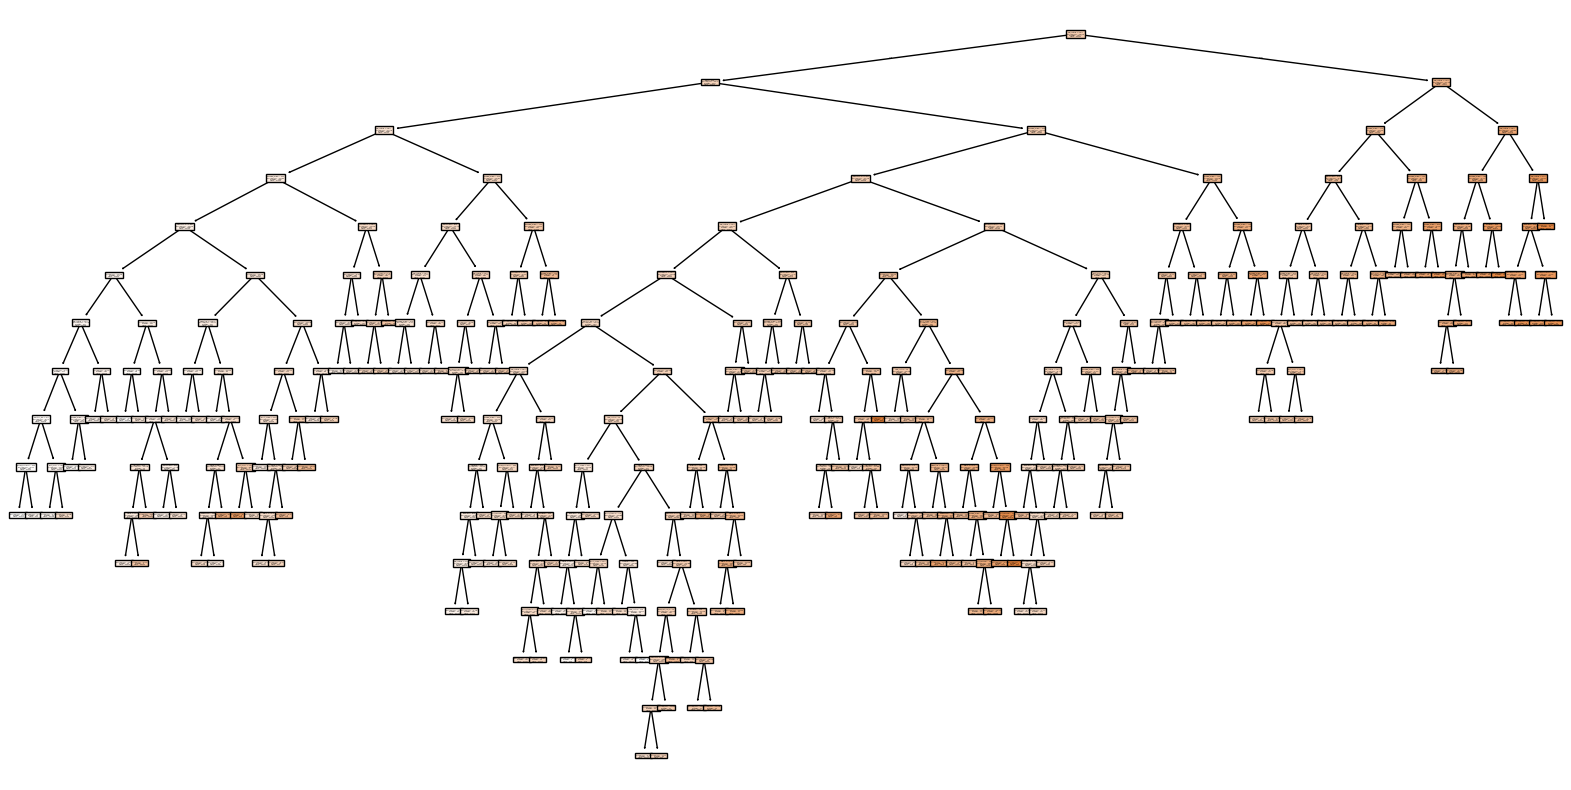

In [48]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.named_steps['dt'], filled=True, feature_names=X.columns)
plt.show()

## Cross validation to evaluate model

In [49]:
df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alphas[best_idx]))
])

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.83369975 0.83052335 0.83405555 0.81407873 0.8186762 ]
R^2 trung bình: 0.826 ± 0.008

MSE: [8.08645531 8.15056958 8.03341306 8.78126006 8.90295032]
MSE trung bình: 8.391± 0.372

MAE: [2.09266545 2.06677675 2.06806954 2.1168852  2.1415223 ]
MAE trung bình: 2.097 ± 0.029


# Genetic algorithm to find optimal decision tree

In [52]:
import pandas as pd

df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [88]:
def create_individual():
    max_depth = np.random.randint(1, 30)
    min_samples_split = np.random.randint(2, 100)
    ccp_alpha = np.random.uniform(0, 0.01)
    while True:
        min_samples_leaf = np.random.randint(1, 50)
        if min_samples_leaf * 2 <= min_samples_split:
            break
    return [max_depth, min_samples_split, ccp_alpha, min_samples_leaf]

def fitness(individual):
    max_depth, min_samples_split, ccp_alpha, min_samples_leaf = individual
    
    model = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(
            random_state=42, 
            max_depth=max_depth, 
            min_samples_split=min_samples_split,
            ccp_alpha=ccp_alpha,
            min_samples_leaf=min_samples_leaf
        ))
    ])
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    return -scores.mean(),

def create_population(pop_size):
    return [create_individual() for _ in range(pop_size)]

def crossover(ind1, ind2, crossover_rate=0.9):
    child1, child2 = ind1[:], ind2[:]
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(ind1))
        child1 = ind1[:crossover_point] + ind2[crossover_point:]
        child2 = ind2[:crossover_point] + ind1[crossover_point:]
        # for i in range(len(ind1)):
        #     if np.random.rand() < 0.5:
        #         child1[i], child2[i] = child2[i], child1[i]
    def check(child):
        min_samples_split = child[1]
        min_samples_leaf = child[3]
        if min_samples_leaf * 2 > min_samples_split:
            child[3] = min_samples_split // 2
        return child
    child1 = check(child1)
    child2 = check(child2)
    return child1, child2

def mutate(individual, mutation_rate=0.05):
    # if np.random.rand() < mutation_rate:
    #     mutation_point = np.random.randint(0, len(individual))
    #     if mutation_point == 0:
    #         individual[mutation_point] = np.random.randint(1, 30)
    #     elif mutation_point == 1:
    #         individual[mutation_point] = np.random.randint(2, 100)
    #     elif mutation_point == 2:
    #         individual[mutation_point] = np.random.uniform(0, 0.1)
    #     else:
    #         while True:
    #             individual[mutation_point] = np.random.randint(1, 50)
    #             if individual[mutation_point] * 2 <= individual[1]:
    #                 break
    # return individual
    mutated = individual[:]
    for i in range(len(mutated)):
        if np.random.rand() < mutation_rate:
            if i != 3:
                mutated[i] = create_individual()[i]
            else:
                while True:
                    mutated[i] = np.random.randint(1, 50)
                    if mutated[i] * 2 <= mutated[1]:
                        break
    return mutated

In [89]:
def genetic_algorithm(pop_size, generations, generations_values, fitness_values):
    population = create_population(pop_size)

    for generation in range(generations):
        scores = [fitness(ind) for ind in population]
        sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]

        print(f'Generation {generation + 1}: Best MSE: {scores[0][0]:.3f}')
        print(f'Solution: {sorted_population[0]}')

        generations_values.append(generation + 1)
        fitness_values.append(-scores[0][0])

        # Elitism
        parents = sorted_population[:5]
        # print('Parents:\n', parents)

        next_generation = parents[:]

        while len(next_generation) < pop_size:
            # Selection
            idx1 = np.random.randint(0, len(parents))
            while True:
                idx2 = np.random.randint(0, len(parents))
                if idx2 != idx1:
                    break
            parent1, parent2 = parents[idx1], parents[idx2]

            # Crossover
            child1, child2 = crossover(parent1, parent2)

            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_generation.append(child1)
            next_generation.append(child2)

        population = next_generation
    
    scores = [fitness(ind) for ind in population]
    # print(scores)
    sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]
    return sorted_population[0]

In [90]:
pop_size = 100
generations = 50

generation_values = []
fitness_values = []

best_individual = genetic_algorithm(pop_size, generations, generation_values, fitness_values)
best_individual

Generation 1: Best MSE: 8.537
Solution: [17, 33, 0.0004872495324492965, 9]
Generation 2: Best MSE: 8.060
Solution: [25, 34, 0.0004872495324492965, 9]
Generation 3: Best MSE: 8.037
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 4: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 5: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 6: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 7: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 8: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 9: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 10: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 11: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 12: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 13: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 14: Best M

[17, 35, 0.0004872495324492965, 9]

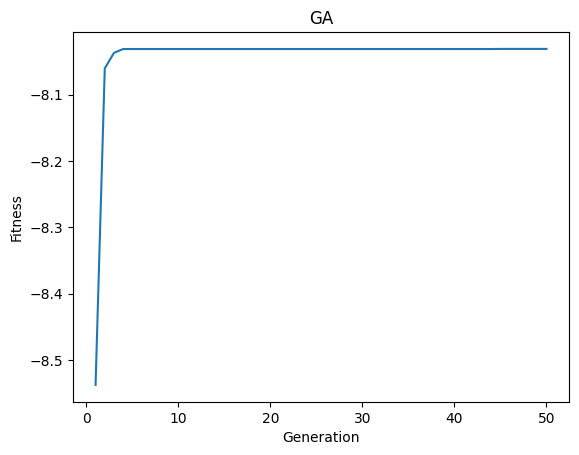

In [91]:
import matplotlib.pyplot as plt

plt.plot(generation_values, fitness_values)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('GA')
plt.show()

In [92]:
best_individual

[17, 35, 0.0004872495324492965, 9]

In [93]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(
        random_state=42, 
        max_depth=best_individual[0], 
        min_samples_split=best_individual[1],
        ccp_alpha=best_individual[2],
        min_samples_leaf=best_individual[3]
    ))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=0.0004872495324492965,
                                       max_depth=17, min_samples_leaf=9,
                                       min_samples_split=35,
                                       random_state=42))])

In [94]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 3.942
MAE: 1.393
R2: 0.919

Test Set:
MSE: 7.143
MAE: 1.913
R2: 0.852


In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.85061875 0.85025891 0.85117    0.83666176 0.83563459]
R^2 trung bình: 0.845 ± 0.007

MSE: [7.26375854 7.20143578 7.20489798 7.71463949 8.07029777]
MSE trung bình: 7.491± 0.347

MAE: [1.89770924 1.90693549 1.91371609 1.93118149 1.97919983]
MAE trung bình: 1.926 ± 0.029


In [ ]:
# from sklearn.tree import plot_tree

# plt.figure(figsize=(20, 10))
# plot_tree(model.named_steps['dt'], filled=True, feature_names=X.columns)
# plt.show()

In [96]:
from sklearn.tree import export_text

tree_rules = export_text(model.named_steps['dt'], feature_names=X.columns.tolist())
print(tree_rules)

|--- ball_control <= 68.50
|   |--- age <= 22.50
|   |   |--- ball_control <= 58.50
|   |   |   |--- standing_tackle <= 60.50
|   |   |   |   |--- nationality <= 65.58
|   |   |   |   |   |--- age <= 20.50
|   |   |   |   |   |   |--- ball_control <= 52.50
|   |   |   |   |   |   |   |--- marking <= 50.50
|   |   |   |   |   |   |   |   |--- positions_GK <= 0.50
|   |   |   |   |   |   |   |   |   |--- heading_accuracy <= 54.50
|   |   |   |   |   |   |   |   |   |   |--- ball_control <= 45.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- ball_control >  45.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- heading_accuracy >  54.50
|   |   |   |   |   |   |   |   |   |   |--- value: [54.20]
|   |   |   |   |   |   |   |   |--- positions_GK >  0.50
|   |   |   |   |   |   |   |   |   |--- age <= 19.50
|   |   |   |   |   |   |   |   |   |   |

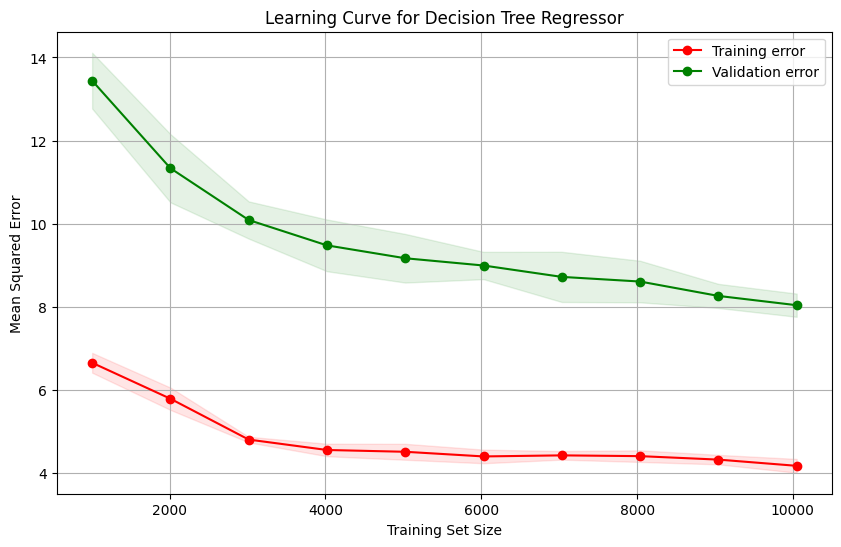

In [97]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve for Decision Tree Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation error")

plt.legend(loc="best")
plt.grid()
plt.show()

# Randomized Search 

In [78]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'dt__max_depth': np.arange(1, 30),
    'dt__min_samples_split': np.arange(2, 100),
    'dt__ccp_alpha': np.linspace(0, 0.1, 100),
    'dt__min_samples_leaf': np.arange(1, 50)
}

model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42))
])

search = RandomizedSearchCV(
    model, 
    param_distributions=param_grid, 
    n_iter=100, 
    cv=cv, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    random_state=42
)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('te',
                                              TargetEncoder(cols=['nationality'])),
                                             ('dt',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'dt__ccp_alpha': array([0.        , 0.0010101 , 0.0020202 , 0.0030303 , 0.0040404 ,
       0.00505051, 0.00606061, 0.00707071, 0.00808081, 0.00909091,
       0...
                                        'dt__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   random_state=42, scoring='neg_mean_squared_error')

In [79]:
search.best_params_

{'dt__min_samples_split': np.int64(40),
 'dt__min_samples_leaf': np.int64(10),
 'dt__max_depth': np.int64(15),
 'dt__ccp_alpha': np.float64(0.0)}

In [80]:
model = search.best_estimator_

mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 4.269
MAE: 1.456
R2: 0.912

Test Set:
MSE: 7.077
MAE: 1.908
R2: 0.853


In [81]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.85058732 0.85291439 0.85003303 0.83617305 0.83703239]
R^2 trung bình: 0.845 ± 0.007

MSE: [7.26528663 7.07372683 7.25993931 7.73772186 8.00166629]
MSE trung bình: 7.468± 0.346

MAE: [1.90460432 1.900742   1.92886802 1.93974476 1.98877219]
MAE trung bình: 1.933 ± 0.032


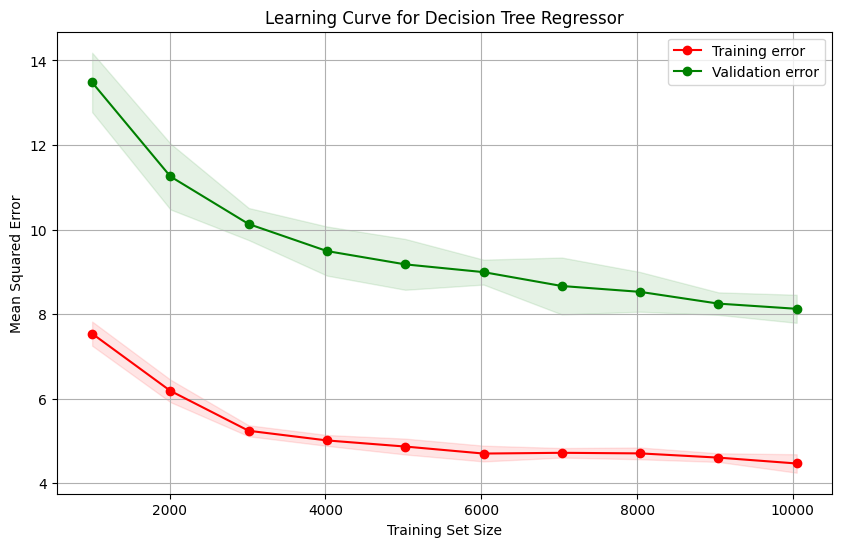

In [ ]:

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve for Decision Tree Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation error")

plt.legend(loc="best")
plt.grid()
plt.show()